# Pipeline

In [4]:
import pandas as pd
import random
import numpy as np

random.seed(42)
np.random.seed(42)

df = pd.read_csv("data.csv")
import numpy as np
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
def classify(df, authors, vectors):
    # Trim the dataset to only include the authors of interest
    df = df[df["author"].isin(authors)].reset_index(drop=True)

    # Make every author have the same number of samples per prompt and make each prompt have the same number of samples
    samples_per_combo = df.groupby(["author", "prompt"]).size().min()
    df = (
        df.groupby(["author", "prompt"], group_keys=True)
        .apply(lambda x: x.sample(samples_per_combo), include_groups=False)
        .reset_index(drop=False, level=[0, 1])
        .reset_index(drop=True)
    )

    # Train-test split
    test_prompts = random.sample(df["prompt"].unique().tolist(), 2)
    df_test = df[df["prompt"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt"].isin(test_prompts)].reset_index(drop=True)

    # Verify that no prompt in the test set is in the train set
    assert (
        len(
            set(df_train["prompt"].unique()).intersection(
                set(df_test["prompt"].unique())
            )
        )
        == 0
    )

    # Pull the vectors out of the dataframe
    X_train = pd.concat(
        [
            df_train[vector].apply(ast.literal_eval).apply(pd.Series)
            for vector in vectors
        ],
        axis=1,
    )
    X_test = pd.concat(
        [
            df_test[vector].apply(ast.literal_eval).apply(pd.Series)
            for vector in vectors
        ],
        axis=1,
    )
    y_train = df_train["author"]
    y_test = df_test["author"]

    # Standardize the vectors
    standardizer = StandardScaler()
    X_train = standardizer.fit_transform(X_train)
    X_test = standardizer.transform(X_test)

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(4):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Verify that no prompt in each validation set is the corresponding train set
    for train_indices, val_indices in cv_iterable:
        assert (
            len(
                set(df_train.loc[train_indices, "prompt"].unique()).intersection(
                    set(df_train.loc[val_indices, "prompt"].unique())
                )
            )
            == 0
        )

    # Train the model using grid search
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_

    # Test the model
    y_pred = model.predict(X_test)

    # Classification report
    return classification_report(y_test, y_pred, output_dict=True, zero_division=0)

In [ ]:
from tqdm import tqdm
from itertools import product


vectors_list = [
    ["common"],
    ["function"],
    ["common", "function"],
    ["bert"],
    ["common", "function", "bert"],
]

authors_list = [
    ["reddit", "gpt"],
    ["reddit", "bard"],
    ["reddit", "gemini"],
    ["bard", "gemini"],
    ["bard", "gpt"],
    ["gemini", "gpt"],
    ["gpt", "bard", "gemini"],
    ["reddit", "gpt", "bard", "gemini"],
    ["reddit", "0.1"],
    ["reddit", "0.2"],
    ["reddit", "0.3"],
    ["reddit", "0.4"],
    ["reddit", "0.5"],
    ["reddit", "0.6"],
    ["reddit", "0.7"],
    ["reddit", "0.8"],
    ["reddit", "0.9"],
    ["reddit", "1.0"],
    ["reddit", "1.1"],
    ["reddit", "1.2"],
    ["reddit", "1.3"],
    ["reddit", "1.4"],
    ["reddit", "1.5"],
]

n_trials = 30

authors_vectors_combos = list(product(authors_list, vectors_list, [0] * n_trials))

results = pd.DataFrame(
    [
        {
            "authors": authors,
            "vectors": vectors,
            "classification_report": classify(df, authors, vectors),
        }
        for authors, vectors, _ in tqdm(authors_vectors_combos)
    ]
)

results.to_csv("classification_results.csv", index=False)

# Ensemble Pipeline

In [ ]:
from itertools import product
import numpy as np
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import random
import pandas as pd
import random
import numpy as np
from tqdm import tqdm

random.seed(42)
np.random.seed(42)

df = pd.read_csv("data.csv")


def classify_ensemble(df, authors):
    vectors = ["common", "function", "bert"]

    # Trim the dataset to only include the authors of interest
    df = df[df["author"].isin(authors)].reset_index(drop=True)

    # Make every author have the same number of samples per prompt and make each prompt have the same number of samples
    samples_per_combo = df.groupby(["author", "prompt"]).size().min()
    df = (
        df.groupby(["author", "prompt"], group_keys=True)
        .apply(lambda x: x.sample(samples_per_combo), include_groups=False)
        .reset_index(drop=False, level=[0, 1])
        .reset_index(drop=True)
    )

    # Train-test split
    test_prompts = random.sample(df["prompt"].unique().tolist(), 2)
    df_test = df[df["prompt"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt"].isin(test_prompts)].reset_index(drop=True)

    # Verify that no prompt in the test set is in the train set
    assert (
        len(
            set(df_train["prompt"].unique()).intersection(
                set(df_test["prompt"].unique())
            )
        )
        == 0
    )

    # Pull the vectors out of the dataframe
    X_trains = [
        df_train[vector].apply(ast.literal_eval).apply(pd.Series) for vector in vectors
    ]
    X_tests = [
        df_test[vector].apply(ast.literal_eval).apply(pd.Series) for vector in vectors
    ]
    y_train = df_train["author"]
    y_test = df_test["author"]

    # Standardize the vectors
    for X_train, X_test in zip(X_trains, X_tests):
        standardizer = StandardScaler()
        X_train = standardizer.fit_transform(X_train)
        X_test = standardizer.transform(X_test)
    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(4):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Verify that no prompt in each validation set is the corresponding train set
    for train_indices, val_indices in cv_iterable:
        assert (
            len(
                set(df_train.loc[train_indices, "prompt"].unique()).intersection(
                    set(df_train.loc[val_indices, "prompt"].unique())
                )
            )
            == 0
        )
    # Train models using grid search
    models = []
    for X_train in X_trains:
        grid_search = GridSearchCV(
            estimator=LogisticRegression(max_iter=1000),
            param_grid={
                "C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                "solver": ["liblinear", "lbfgs"],
            },
            cv=cv_iterable,
            n_jobs=-1,
            refit=True,
        )
        grid_search.fit(X_train, y_train)
        models.append(grid_search.best_estimator_)

    # Get model predictions
    y_preds = [model.predict(X_test) for model, X_test in zip(models, X_tests)]
    y_preds = np.array(y_preds).T

    # Use majority voting, choosing randomly in case of a tie
    def get_vote_result(row):
        unique_values, counts = np.unique(row, return_counts=True)
        max_count = np.max(counts)
        indices = np.where(counts == max_count)[0]
        if len(indices) == 1:
            return unique_values[indices[0]]
        else:
            return random.choice(unique_values[indices])

    y_pred = [get_vote_result(row) for row in y_preds]
    return classification_report(y_test, y_pred, output_dict=True, zero_division=0)


authors_list = [
    ["reddit", "gpt"],
    ["reddit", "bard"],
    ["reddit", "gemini"],
    ["bard", "gemini"],
    ["gpt", "bard", "gemini"],
    ["reddit", "gpt", "bard", "gemini"],
    ["reddit", "0.1"],
    ["reddit", "0.2"],
    ["reddit", "0.3"],
    ["reddit", "0.4"],
    ["reddit", "0.5"],
    ["reddit", "0.6"],
    ["reddit", "0.7"],
    ["reddit", "0.8"],
    ["reddit", "0.9"],
    ["reddit", "1.0"],
    ["reddit", "1.1"],
    ["reddit", "1.2"],
    ["reddit", "1.3"],
    ["reddit", "1.4"],
    ["reddit", "1.5"],
]

n_trials = 30

authors_combos = list(product(authors_list, [0] * n_trials))

results = pd.DataFrame(
    [
        {
            "authors": authors,
            "vectors": "ensemble",
            "classification_report": classify_ensemble(df, authors),
        }
        for authors, _ in tqdm(authors_combos)
    ]
)

results.to_csv("ensemble_classification_results.csv", index=False)

In [6]:
# Merge with the other results dataframe

import pandas as pd

df1 = pd.read_csv("classification_results.csv")
df2 = pd.read_csv("ensemble_classification_results.csv")
df = pd.concat([df1, df2], ignore_index=True)
df.to_csv("classification_results.csv", index=False)

# Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np


results = pd.read_csv("classification_results.csv")

for column in results.columns:
    results[column] = results[column].apply(ast.literal_eval)

results["accuracy"] = results["classification_report"].apply(lambda x: x["accuracy"])
results["macro f1"] = results["classification_report"].apply(
    lambda x: x["macro avg"]["f1-score"]
)
results["macro precision"] = results["classification_report"].apply(
    lambda x: x["macro avg"]["precision"]
)
results["macro recall"] = results["classification_report"].apply(
    lambda x: x["macro avg"]["recall"]
)

results["vectors"] = results["vectors"].apply(lambda x: ", ".join(x))
results["authors"] = results["authors"].apply(lambda x: ", ".join(x))

## Reddit, LLM $\in$ { GPT, Bard, Gemini }

- 800 Reddit, 800 LLM

### Accuracy

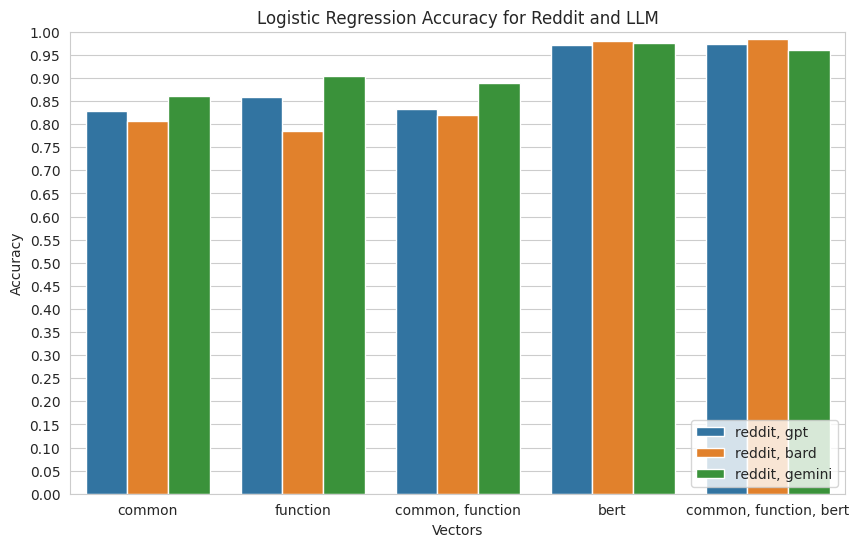

In [2]:
plt.figure(figsize=(10, 6))

sns.set_style("whitegrid")
ax = sns.barplot(
    data=results[
        results["authors"].isin(
            [
                "reddit, gpt",
                "reddit, bard",
                "reddit, gemini",
            ]
        )
        & (results["vectors"] != "ensemble")
    ],
    x="vectors",
    y="accuracy",
    hue="authors",
    errorbar=None,
)

plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.title("Logistic Regression Accuracy for Reddit and LLM")
plt.legend(loc="lower right")
plt.xlabel("Vectors")
plt.ylabel("Accuracy")
plt.show()

In [18]:
(
    results[
        results["authors"].isin(
            [
                "reddit, gpt",
                "reddit, bard",
                "reddit, gemini",
            ]
        )
    ]
    .groupby(["vectors", "authors"])[
        [
            "accuracy",
            "macro precision",
            "macro recall",
            "macro f1",
        ]
    ]
    .mean()
    .round(3)
)

accuracy  macro precision  \
vectors                authors                                     
bert                   reddit, bard       0.981            0.982   
                       reddit, gemini     0.975            0.978   
                       reddit, gpt        0.971            0.973   
common                 reddit, bard       0.808            0.821   
                       reddit, gemini     0.861            0.882   
                       reddit, gpt        0.829            0.861   
common, function       reddit, bard       0.820            0.828   
                       reddit, gemini     0.888            0.905   
                       reddit, gpt        0.833            0.873   
common, function, bert reddit, bard       0.985            0.985   
                       reddit, gemini     0.960            0.970   
                       reddit, gpt        0.973            0.976   
function               reddit, bard       0.784            0.792   
                       reddit, gemini     0.905            0.916   
                       reddit, gpt        0.858            0.890   

                                       macro recall  macro f1  
vectors                authors                                 
bert                   reddit, bard           0.981     0.981  
                       reddit, gemini         0.975     0.975  
                       reddit, gpt            0.971     0.971  
common                 reddit, bard           0.808     0.805  
                       reddit, gemini         0.861     0.856  
                       reddit, gpt            0.829     0.822  
common, function       reddit, bard           0.820     0.818  
                       reddit, gemini         0.888     0.885  
                       reddit, gpt            0.833     0.823  
common, function, bert reddit, bard           0.985     0.985  
                       reddit, gemini         0.960     0.959  
                       reddit, gpt            0.973     0.973  
function               reddit, bard           0.784     0.780  
                       reddit, gemini         0.905     0.902  
                       reddit, gpt            0.858     0.851

## 3 Additional Experiments

- Bard, Gemini
- GPT, Bard, Gemini
- Reddit, GPT, Bard, Gemini

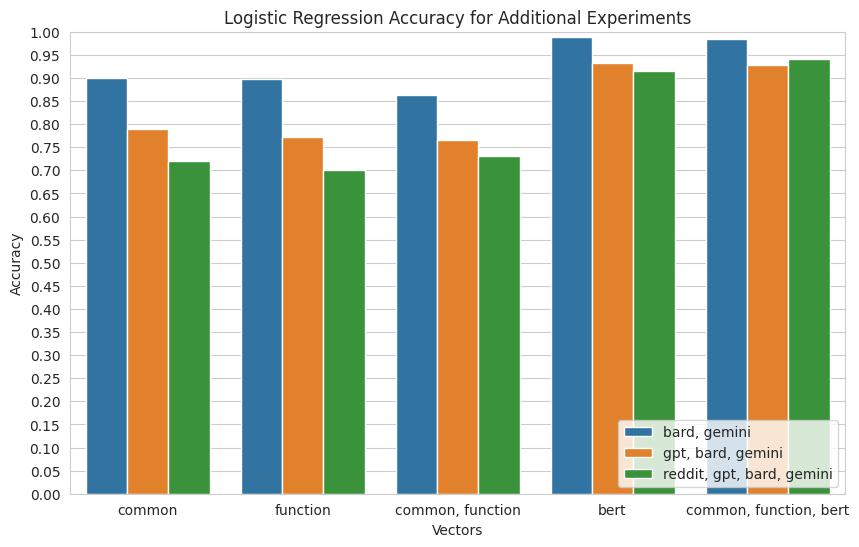

In [63]:
plt.figure(figsize=(10, 6))

sns.set_style("whitegrid")
ax = sns.barplot(
    data=results[
        results["authors"].isin(
            [
                "bard, gemini",
                "gpt, bard, gemini",
                "reddit, gpt, bard, gemini",
            ]
        )
        & (results["vectors"] != "ensemble")
    ],
    x="vectors",
    y="accuracy",
    hue="authors",
    errorbar=None,
)

plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.title("Logistic Regression Accuracy for Additional Experiments")
plt.legend(loc="lower right")
plt.xlabel("Vectors")
plt.ylabel("Accuracy")
plt.show()

In [17]:
(
    results[
        results["authors"].isin(
            [
                "bard, gemini",
                "gpt, bard, gemini",
                "reddit, gpt, bard, gemini",
            ]
        )
    ]
    .groupby(["vectors", "authors"])[
        [
            "accuracy",
            "macro precision",
            "macro recall",
            "macro f1",
        ]
    ]
    .mean()
    .round(3)
)

accuracy  macro precision  \
vectors                authors                                                
bert                   bard, gemini                  0.988            0.988   
                       gpt, bard, gemini             0.933            0.942   
                       reddit, gpt, bard, gemini     0.916            0.925   
common                 bard, gemini                  0.899            0.920   
                       gpt, bard, gemini             0.788            0.810   
                       reddit, gpt, bard, gemini     0.719            0.744   
common, function       bard, gemini                  0.863            0.903   
                       gpt, bard, gemini             0.767            0.794   
                       reddit, gpt, bard, gemini     0.730            0.760   
common, function, bert bard, gemini                  0.983            0.985   
                       gpt, bard, gemini             0.928            0.941   
                       reddit, gpt, bard, gemini     0.942            0.951   
function               bard, gemini                  0.898            0.924   
                       gpt, bard, gemini             0.772            0.818   
                       reddit, gpt, bard, gemini     0.701            0.728   

                                                  macro recall  macro f1  
vectors                authors                                            
bert                   bard, gemini                      0.988     0.988  
                       gpt, bard, gemini                 0.933     0.933  
                       reddit, gpt, bard, gemini         0.916     0.915  
common                 bard, gemini                      0.899     0.892  
                       gpt, bard, gemini                 0.788     0.783  
                       reddit, gpt, bard, gemini         0.719     0.714  
common, function       bard, gemini                      0.863     0.851  
                       gpt, bard, gemini                 0.767     0.759  
                       reddit, gpt, bard, gemini         0.730     0.724  
common, function, bert bard, gemini                      0.983     0.983  
                       gpt, bard, gemini                 0.928     0.926  
                       reddit, gpt, bard, gemini         0.942     0.941  
function               bard, gemini                      0.898     0.892  
                       gpt, bard, gemini                 0.772     0.764  
                       reddit, gpt, bard, gemini         0.701     0.697

## GPT temp $\in \{0.1,...,1.5\}$

For each of the 15 temperature values: 200 reddit, 200 GPT

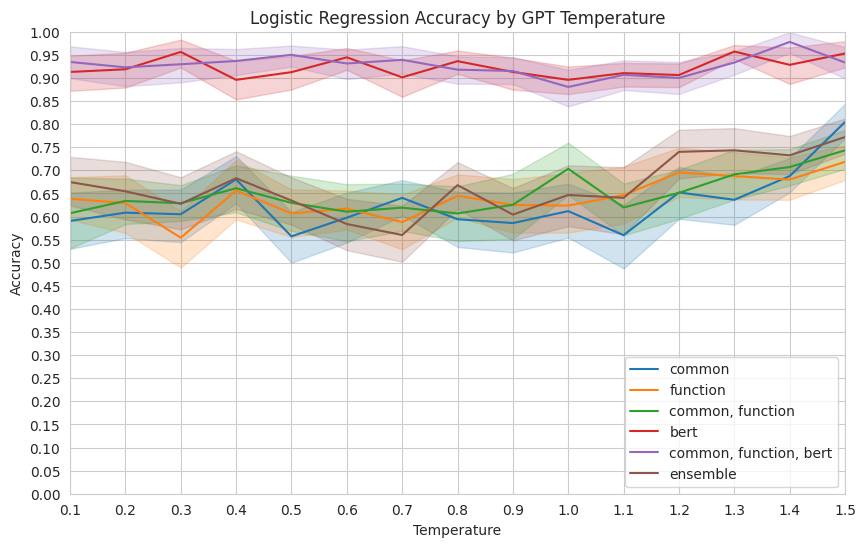

In [65]:
import re


def extract_temp(x):
    digits = re.sub(r"[^0-9\.]", "", x)
    return float(digits) if digits else None


results["numeric_authors"] = results["authors"].apply(extract_temp)

plt.figure(figsize=(10, 6))

sns.set_style("whitegrid")
ax = sns.lineplot(
    data=results[results["authors"].str.contains("\.")],
    x="numeric_authors",
    y="accuracy",
    hue="vectors",
)

plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xlim(0.1, 1.5)
plt.xticks(np.arange(0.1, 1.6, 0.1))
plt.title("Logistic Regression Accuracy by GPT Temperature")
plt.legend(loc="lower right")
plt.xlabel("Temperature")
plt.ylabel("Accuracy")
plt.show()

In [23]:
temps_results = (
    results[results["authors"].str.contains("\.")]
    .groupby(["vectors", "authors"])[
        [
            "accuracy",
            "macro precision",
            "macro recall",
            "macro f1",
        ]
    ]
    .mean()
    .round(3)
)
temps_results

accuracy  macro precision  macro recall  macro f1
vectors  authors                                                       
bert     reddit, 0.1     0.913            0.934         0.913     0.908
         reddit, 0.2     0.919            0.938         0.919     0.915
         reddit, 0.3     0.956            0.966         0.956     0.954
         reddit, 0.4     0.896            0.923         0.896     0.890
         reddit, 0.5     0.912            0.935         0.912     0.908
...                        ...              ...           ...       ...
function reddit, 1.1     0.646            0.654         0.646     0.637
         reddit, 1.2     0.695            0.714         0.695     0.687
         reddit, 1.3     0.688            0.708         0.688     0.668
         reddit, 1.4     0.680            0.701         0.680     0.660
         reddit, 1.5     0.718            0.744         0.718     0.696

[75 rows x 4 columns]

## All binary classifiers

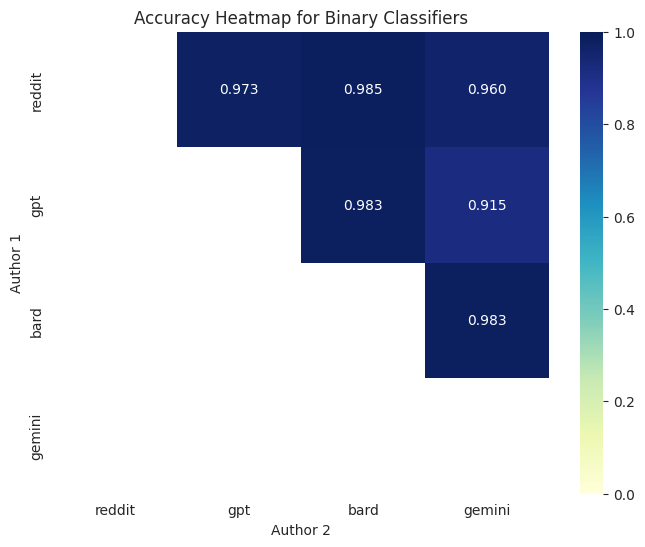

(180, 3)


In [8]:
def key_func(author):
    if "reddit" in author:
        return 0
    if "gpt" in author:
        return 1
    if "bard" in author:
        return 2
    if "gemini" in author:
        return 3
    return 4


authors = ["reddit", "gpt", "bard", "gemini"]

results["authors_list"] = results["authors"].apply(lambda x: x.split(", "))
results["author_1"] = results["authors_list"].apply(
    lambda x: sorted(x, key=key_func)[0]
)
results["author_2"] = results["authors_list"].apply(
    lambda x: sorted(x, key=key_func)[1]
)
binaries = results[
    (results["vectors"] == "common, function, bert")
    & (results["authors_list"].apply(len) == 2)
    & results["author_1"].isin(authors)
    & results["author_2"].isin(authors)
][["author_1", "author_2", "accuracy"]].reset_index(drop=True)

pivot_df = binaries.pivot_table(
    index="author_1",
    columns="author_2",
    values="accuracy",
    aggfunc="mean",
    fill_value=np.nan,
).reindex(index=authors, columns=authors, fill_value=np.nan)

sns.set_style("white")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".3f", vmin=0, vmax=1)
plt.title("Accuracy Heatmap for Binary Classifiers")
plt.xlabel("Author 2")
plt.ylabel("Author 1")
plt.show()

print(binaries.shape)

# Confusion matrix for quad classifier

In [2]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import numpy as np
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


random.seed(42)
np.random.seed(42)

df = pd.read_csv("data.csv")


def classify2(df, authors, vectors):
    # Trim the dataset to only include the authors of interest
    df = df[df["author"].isin(authors)].reset_index(drop=True)

    # Make every author have the same number of samples per prompt and make each prompt have the same number of samples
    samples_per_combo = df.groupby(["author", "prompt"]).size().min()
    df = (
        df.groupby(["author", "prompt"], group_keys=True)
        .apply(lambda x: x.sample(samples_per_combo), include_groups=False)
        .reset_index(drop=False, level=[0, 1])
        .reset_index(drop=True)
    )

    # Train-test split
    test_prompts = random.sample(df["prompt"].unique().tolist(), 2)
    df_test = df[df["prompt"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt"].isin(test_prompts)].reset_index(drop=True)

    # Verify that no prompt in the test set is in the train set
    assert (
        len(
            set(df_train["prompt"].unique()).intersection(
                set(df_test["prompt"].unique())
            )
        )
        == 0
    )

    # Pull the vectors out of the dataframe
    X_train = pd.concat(
        [
            df_train[vector].apply(ast.literal_eval).apply(pd.Series)
            for vector in vectors
        ],
        axis=1,
    )
    X_test = pd.concat(
        [
            df_test[vector].apply(ast.literal_eval).apply(pd.Series)
            for vector in vectors
        ],
        axis=1,
    )
    y_train = df_train["author"]
    y_test = df_test["author"]

    # Standardize the vectors
    standardizer = StandardScaler()
    X_train = standardizer.fit_transform(X_train)
    X_test = standardizer.transform(X_test)

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(4):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Verify that no prompt in each validation set is the corresponding train set
    for train_indices, val_indices in cv_iterable:
        assert (
            len(
                set(df_train.loc[train_indices, "prompt"].unique()).intersection(
                    set(df_train.loc[val_indices, "prompt"].unique())
                )
            )
            == 0
        )

    # Train the model using grid search
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_

    # Test the model
    y_pred = model.predict(X_test)

    return y_test, y_pred

In [ ]:
authors = ["reddit", "gpt", "bard", "gemini"]
vectors = ["common", "function", "bert"]

results = []
for _ in tqdm(range(30)):
    y_test, y_pred = classify2(df, authors, vectors)
    results.append({"y_test": y_test, "y_pred": y_pred})
results = pd.DataFrame(results)
results.to_csv("quad_true_pred.csv", index=False)

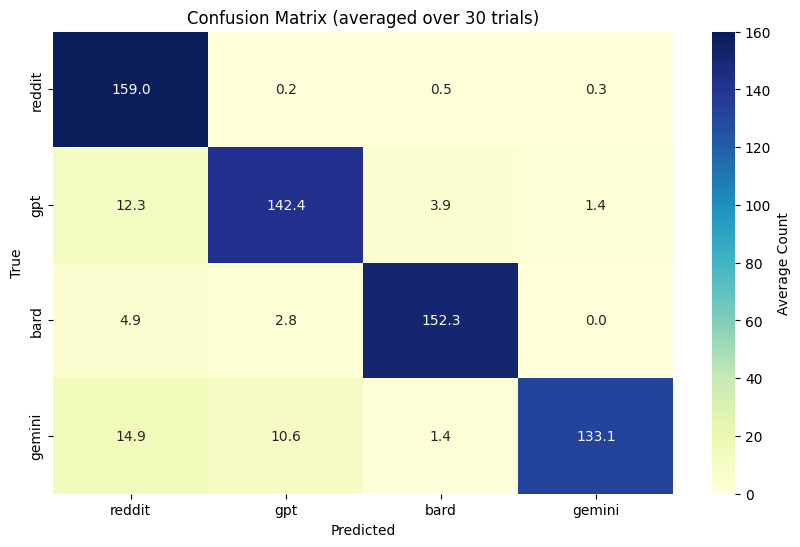

In [52]:
# construct the confusion matrix from the average of the 30 trials
from sklearn.metrics import confusion_matrix
import ast

results = pd.read_csv("quad_true_pred.csv")
for column in results.columns:
    results[column] = results[column].apply(ast.literal_eval)

cm = np.zeros((4, 4))
for _, row in results.iterrows():
    cm += confusion_matrix(row["y_test"], row["y_pred"], labels=authors)
cm /= len(results)

# plot with seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=authors,
    yticklabels=authors,
    fmt=".1f",
    cbar_kws={"label": "Average Count"},
    cmap="YlGnBu",
    vmin=0,
    vmax=160,
)
plt.title("Confusion Matrix (averaged over 30 trials)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Examples between Reddit and GPT

1. Where CF, Bert classification both get it right
2. Where they both get it wrong
3. Where CF get it right and Bert gets it wrong
4. Vise versa

In [12]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import numpy as np
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


random.seed(42)
np.random.seed(42)

df = pd.read_csv("data.csv")

authors = ["reddit", "gpt"]
style_vectors = ["common", "function"]
semantic_vectors = ["bert"]

# Trim the dataset to only include the authors of interest
df = df[df["author"].isin(authors)].reset_index(drop=True)

# Make every author have the same number of samples per prompt and make each prompt have the same number of samples
samples_per_combo = df.groupby(["author", "prompt"]).size().min()
df = (
    df.groupby(["author", "prompt"], group_keys=True)
    .apply(lambda x: x.sample(samples_per_combo), include_groups=False)
    .reset_index(drop=False, level=[0, 1])
    .reset_index(drop=True)
)

# Train-test split
test_prompts = random.sample(df["prompt"].unique().tolist(), 2)
df_test = df[df["prompt"].isin(test_prompts)].reset_index(drop=True)
df_train = df[~df["prompt"].isin(test_prompts)].reset_index(drop=True)

# Verify that no prompt in the test set is in the train set
assert (
    len(set(df_train["prompt"].unique()).intersection(set(df_test["prompt"].unique())))
    == 0
)

y_preds = []
for vectors in [style_vectors, semantic_vectors]:
    # Pull the vectors out of the dataframe
    X_train = pd.concat(
        [
            df_train[vector].apply(ast.literal_eval).apply(pd.Series)
            for vector in vectors
        ],
        axis=1,
    )
    X_test = pd.concat(
        [
            df_test[vector].apply(ast.literal_eval).apply(pd.Series)
            for vector in vectors
        ],
        axis=1,
    )
    y_train = df_train["author"]
    y_test = df_test["author"]
    y_responses = df_test["response"]

    # Standardize the vectors
    standardizer = StandardScaler()
    X_train = standardizer.fit_transform(X_train)
    X_test = standardizer.transform(X_test)

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(4):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Verify that no prompt in each validation set is the corresponding train set
    for train_indices, val_indices in cv_iterable:
        assert (
            len(
                set(df_train.loc[train_indices, "prompt"].unique()).intersection(
                    set(df_train.loc[val_indices, "prompt"].unique())
                )
            )
            == 0
        )

    # Train the model using grid search
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_

    # Test the model
    y_pred = model.predict(X_test)
    y_preds.append(y_pred)

y_pred_style, y_pred_semantic = y_preds

df_results = pd.DataFrame(
    {
        "response": y_responses,
        "true_author": y_test,
        "style_author": y_pred_style,
        "semantic_author": y_pred_semantic,
    }
)

In [13]:
correct_both = (df_results["true_author"] == df_results["style_author"]) & (
    df_results["true_author"] == df_results["semantic_author"]
)
df_both_correct = df_results[correct_both]
df_both_correct

,response,true_author,style_author,semantic_author
80,"Once upon a time , there was a king who had th...",gpt,gpt,gpt
81,Alice had to find a way to break free . She ha...,gpt,gpt,gpt
82,Once upon a time there was a small town called...,gpt,gpt,gpt
83,"Once upon a time , in a small village far away...",gpt,gpt,gpt
84,"Once upon a time , there lived a small family ...",gpt,gpt,gpt
...,...,...,...,...
315,Interlude : Growing up / Location : A World Be...,reddit,reddit,reddit
316,"I 've been bullied , all my life . There 's no...",reddit,reddit,reddit
317,Tim grabbed his mother 's hand and calmly said...,reddit,reddit,reddit
318,"Sunlight is leaking through the trees , hittin...",reddit,reddit,reddit


In [14]:
wrong_both = (df_results["true_author"] != df_results["style_author"]) & (
    df_results["true_author"] != df_results["semantic_author"]
)
df_both_wrong = df_results[wrong_both]
df_both_wrong

,response,true_author,style_author,semantic_author
7,"As last year 's champion , I had to bring my A...",gpt,reddit,reddit
8,Last year 's championship was a lot of fun ! T...,gpt,reddit,reddit
13,My victory in the Killing Hitler sport last ye...,gpt,reddit,reddit
16,Last year 's championship was won with a creat...,gpt,reddit,reddit
19,I won last year 's competition by going back t...,gpt,reddit,reddit
29,I won last year ’ s competition by doing somet...,gpt,reddit,reddit
35,I won the Time Travel Killing Hitler Tournamen...,gpt,reddit,reddit
41,"Last year , I won the time traveler 's competi...",gpt,reddit,reddit
46,Last year I took home the title of 'Time-Trave...,gpt,reddit,reddit
52,The year before last I was determined to take ...,gpt,reddit,reddit


In [15]:
style_correct_semantic_wrong = (
    df_results["true_author"] == df_results["style_author"]
) & (df_results["true_author"] != df_results["semantic_author"])
df_style_correct_semantic_wrong = df_results[style_correct_semantic_wrong]
df_style_correct_semantic_wrong

,response,true_author,style_author,semantic_author


In [16]:
semantic_correct_style_wrong = (
    df_results["true_author"] != df_results["style_author"]
) & (df_results["true_author"] == df_results["semantic_author"])
df_semantic_correct_style_wrong = df_results[semantic_correct_style_wrong]
df_semantic_correct_style_wrong

,response,true_author,style_author,semantic_author
0,"Last year , I was crowned the champion of kill...",gpt,reddit,gpt
1,"I had been time traveling for ages , using var...",gpt,reddit,gpt
2,My victory was hard-earned but very satisfying...,gpt,reddit,gpt
3,"Last year , I managed to snag the grand prize ...",gpt,reddit,gpt
4,Last year 's competition was fierce and I was ...,gpt,reddit,gpt
...,...,...,...,...
148,"Once upon a time , there was a young girl who ...",gpt,reddit,gpt
150,"Once upon a time , there was a young boy named...",gpt,reddit,gpt
151,Once upon a time there was a mischievous littl...,gpt,reddit,gpt
152,The story I 've been thinking about sharing is...,gpt,reddit,gpt
